# Model of heavy drinking among high school student

This section of the analysis will attempt to construct a model to predict:

* heavy_drinker - a higher level (4-5) of weekend alcohol consumption accompanied by a high level (4-5) of weekday alcohol consumption.
* Walc - level of workday alcohol consumption
* Dalc - level of weekend alcohol consumption

In [152]:
import pandas as pd
import numpy as np

import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PowerTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import roc_curve, auc, confusion_matrix
%matplotlib inline 
#to allow plots to render in the notebook

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

In [143]:
class ModelFitter:
    
    def __init__(self):
        pass
    
    def fit_model(self, model, X_train, y_train):
        #for something more complex with pipelines and gridSearch, will want to ?execute? that first before fitting
        model = model(X_train, y_train)
        model.fit(X_train, y_train)
        return model
    

class AlcoholStudyDataPreparer:
    
    def __init__(self):
        pass
    
    def read_in_data_from(self, path):
        self.data = pd.read_csv(path)
    
    def data_length_checker(self):
        print("There are ", str(self.data.shape[1]), " columns in the data")
    
    def move_alcohol_related_variables_to_end_of_column_list(self, data):
        
        self.data = data
        self.data_length_checker()
        print("Moving alcohol related variables to the end of the list")
        alcohol_related_variables = ["binge_drinker", "heavy_drinker", "Dalc", "Walc"]

        cols = self.data.columns.tolist()
        cols = set(cols) - set(alcohol_related_variables) - set(["Unnamed: 0"])
        cols = list(cols) + alcohol_related_variables
        self.data = data[cols]
        self.data_length_checker()
        return
    
    def ready_data_for_experiments(self, path):
        self.read_in_data_from(path)
        self.move_alcohol_related_variables_to_end_of_column_list(self.data)
        print(self.data.shape)
        return self
    
    def plot_dependent_variable(self):
        
        data = self.data
        f, ax = plt.subplots(1,1)
        sns.countplot("heavy_drinker", data=data, ax=ax);
        f.suptitle("Distribution of heavy drinkers");
        data.groupby(data["heavy_drinker"])["heavy_drinker"].count()

class Evaluation:
    
    def print_accuracy_score(self, model, data):
        print("Hi evaluation")
        print("Accuracy is: " + str(model.score(data.X_train, data.y_train)))
        
    def print_confusion_matrix(self, model, data, figsize = (10,7), fontsize=14, model_name="model"):
        
        #tweaked from shyapal5 https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
        f, (ax1, ax2) = plt.subplots(1,2)
        
        def __create_single_heatmap():
        y_pred_test = model.predict(data.X_test)
        conf_matrix = confusion_matrix(data.y_test, y_pred_test)
        class_names = ["normal_drinker", "heavy_drinker"]

        df_cm = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        fig.suptitle(str("Confusion matrix for test set"))
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return fig

    
    
class Experiment:
    
    def __init__(self):
        pass
    
    def separate_X_from_y(self, y_col_name):
        
        self.X = self.data.iloc[:, :-4]
        self.y = self.data.loc[:, y_col_name].values.reshape(-1,)
        return self.X, self.y
    
    def divide_into_training_and_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state=0)
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def fit_model_and_evaluate(self, model, evaluation):
        fit_model = ModelFitter().fit_model(model, self.X_train, self.y_train)
        evaluation(fit_model, self)
        return fit_model
        
    def run_experiment(self, data, y_col_name, model, evaluation):
        
        self.data = data
        self.separate_X_from_y(y_col_name)
        self.divide_into_training_and_test()
        fit_model = self.fit_model_and_evaluate(model, evaluation)
        return fit_model

class PCAInvestigator:
    
    def __init__(self, pca, data):
        self.pca = pca
        self.data = data
        self.create_pca_df()
        self.transformed = self.transform_to_pca_components()
        pass

    def create_pca_df(self):
        components = self.pca.components_
        self.component_labels = [("PCA" + str(i+1)) for i, val in enumerate(components)]
        df = pd.DataFrame(data=components, columns=self.data.X_train.columns).transpose()
        df.columns = self.component_labels
        self.df = df
        return df
    
    def get_n_largest_features_for_component(self, component_name, n):
        
        abs_col = str(component_name + "_abs")
        self.df[abs_col] = self.df[component_name].abs() #for ranking purposes, we need the absolute value of the coeff
        components = self.df.nlargest(n, abs_col)[[component_name, abs_col]]
        df = pd.DataFrame(data=components).reset_index() #unhooks the feature names from the index
        df["rank"] = df[abs_col].rank(ascending=False)
        df = df.loc[:, ["index", component_name, "rank"]] #after we have rank, we no longer need abs_col
        df.columns=["feature_name", "variance_explained", "rank"]
        return df.set_index("rank")
    
    def get_n_largest_features_for_pca(self, n):

        n_largest_features = [self.get_n_largest_features_for_component(label, n) for label in self.component_labels]
        #pretty much nothing for here below is robust to situations where pca components > 2
        if len(n_largest_features) > 1:
            df = pd.merge(n_largest_features[0], n_largest_features[1], on="rank", suffixes=("_PCA1", "_PCA2"))
            df = df.set_index("rank")
            self.largest_features_per_factor = df
        else:
            self.largest_features_per_factor = n_largest_features[0]
        return self.largest_features_per_factor
    
    def transform_to_pca_components(self):
        
        pca_results = self.pca.transform(self.data.X_train)
        pca_results = pd.DataFrame(data=pca_results)
        pca_results.columns = self.component_labels
        pca_results["heavy_drinker"] = self.data.y_train
        return pca_results
    
    def plot_pca_components(self):
        
        f, ax = plt.subplots(1,1, figsize = (10,7))
        f.suptitle("Heavy Drinker instances across PCA1 vs PCA2")
        sns.scatterplot("PCA1", "PCA2", hue="heavy_drinker", data=self.transformed);
        
    def plot_pca_component(self):
        
        f, ax = plt.subplots(1,1, figsize = (10,7))
        f.suptitle("Distribution of heavy drinkers across PCA1")
        sns.swarmplot(x="heavy_drinker", y="PCA1", data=self.transformed);

        

# Reading in file and checking columns

In [155]:
asdp = AlcoholStudyDataPreparer().ready_data_for_experiments('../input/student_math_por_formatted.csv')

There are  51  columns in the data
Moving alcohol related variables to the end of the list
There are  50  columns in the data
(1044, 50)


# Metric Selection

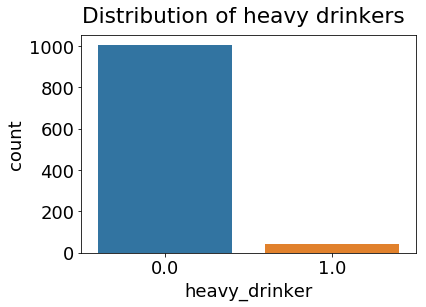

In [156]:
asdp.plot_dependent_variable()

The figure above shows that the classes are imbalanced; accuracy may not be a suitable measure.

Take, for example, an accuracy of 95%. Since the heavy drinkers make up less than 5% of the sample, a classifier could fail to detect all of the heavy drinkers in the sample and still achieve a 95% accuracy.

Effectiveness of this model would be finding all the heavy drinkers so that they can be targeted for any interventions.

# Modelling
## Baseline performance: Stratified Dummy Classifier

accuracy score: 0.931034482759


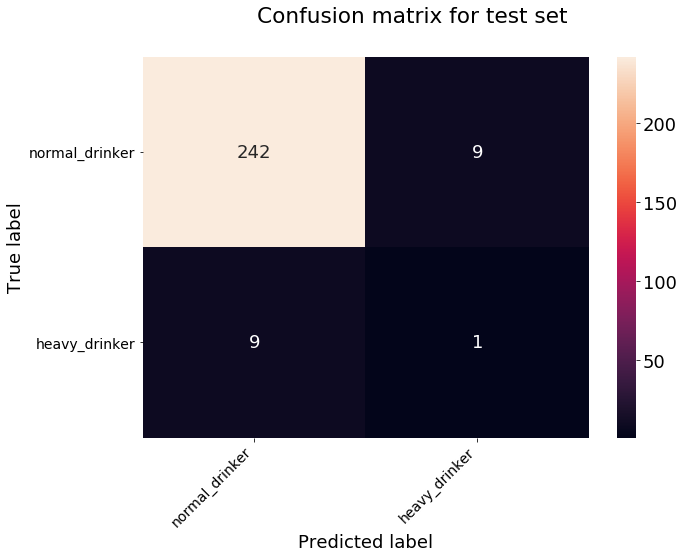

In [5]:
#exp1_classifier = DummyClassifier(strategy="stratified", random_state=0)
def exp1_classifier(X_train, y_train):
    return DummyClassifier(strategy="stratified", random_state=0)

exp1_eval = Evaluation().print_confusion_matrix
exp1 = Experiment()
dummy = exp1.run_experiment(asdp.data, "heavy_drinker", exp1_classifier,exp1_eval)
print("accuracy score: " + str(dummy.score(exp1.X_test, exp1.y_test)))

### Lots of room for improvement
The results above illustrate the point exactly. The accuracy score is 93%. However, as can be seen from the confusion matrix, only one heavy_drinker was predicted correctly. What's worse, nine normal drinkers were incorrectly classified as heavy drinkers and nine heavy drinkers were incorrectly classified as normal drinkers.

A dummy classifier is meant to give us only a baseline of the predictive power. Hopefully, things will only improve from here!

## Logistic Regression Approach
### Preprocessing
1. Remove collinearity by applying PCA.
2. Investigate factors for linear relationship with heavy_drinker variable.
3. Apply transformations as required to remove outliers

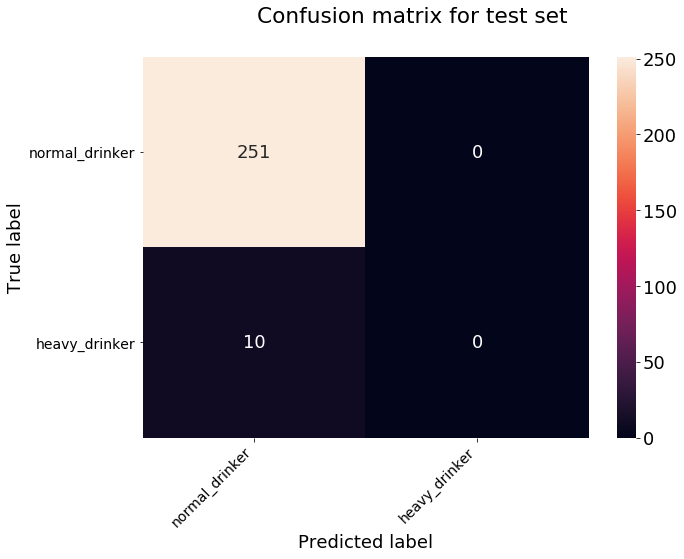

In [151]:
def exp2_classifier(X_train, y_train):
    
    estimators = [('robust_scaler', RobustScaler()), 
                  ('reduce_dim', PCA(random_state=0)), 
                  ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
                  ('clf', LogisticRegression(random_state=0, solver="liblinear"))] 
                #solver specified here to suppress warnings, it doesn't seem to effect gridSearch
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    param_grid = dict(reduce_dim__n_components=[1, 2, 3, 4, 5, 10],
                    clf__solver=["liblinear", "lbfgs"])
    return GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="recall", iid=False)

exp2_eval = Evaluation().print_confusion_matrix
exp2 = Experiment()
logit_grid = exp2.run_experiment(asdp.data, "heavy_drinker", exp2_classifier, exp2_eval);

#TODO: link this kernel here: https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search#354172

Unfortunately, the recall on logistic regression seems slightly worse than the dummy classifier. On the bright side, it is not misclassifying normal drinkers as heavy drinkers as the dummy classifier was doing for nine students.

Let's take a closer look at what's going on with the components we ended up with

In [138]:
pca_investigation = PCAInvestigator(logit_grid.best_estimator_.steps[1][1], exp2)
pca_investigation.get_n_largest_features_for_pca(10)


,feature_name,variance_explained
rank,,
1.0,G3,-0.560277
2.0,G2,-0.470097
3.0,overall_grade,-0.465954
4.0,G1,-0.389652
5.0,failures,0.170762
6.0,studytime,-0.115829
7.0,traveltime,0.089033
8.0,Medu,-0.085786
9.0,Fedu,-0.070719


The grid search cross validation ended up collapsing most of the variables to a single factor. From the highest rank variables above, it appears to be related to academic achievement (grades, failures, studytime).

It's a bit of a strange result given that the performance of the GridSearchCV is optimised for recall.

No wonder the classifier is having such a hard time picking up the heavy drinkers in the sample.

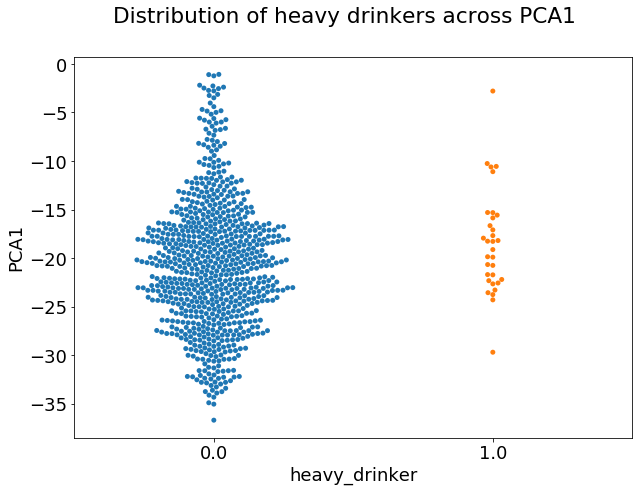

In [141]:
pca_investigation.plot_pca_component()

And this shows us why the classifier was having such a hard time isolating the heavy drinkers: The single factor coming out of the PCA shows the heavy drinkers somewhat evenly distributed among the normal drinkers.

It seems unlikely that any of the simpler models like LDA or Linear SVM will be able to separate the classes. Thus, the more complex models will be used, even though some interpetability will be sacrificed.
# Gradient Boosted Decision Trees
At this stage, it is something of a last ditch effort.

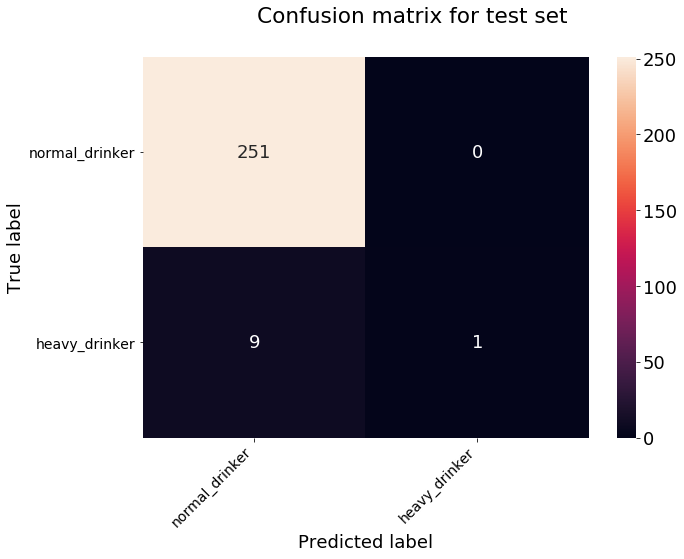

In [153]:
def exp3_classifier(X_train, y_train):
    
    estimators = [('robust_scaler', RobustScaler()), 
                  ('reduce_dim', PCA(random_state=0)), 
                  ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
                  ('clf', GradientBoostingClassifier(random_state=0))] 
                #solver specified here to suppress warnings, it doesn't seem to effect gridSearch
    pipe = Pipeline(estimators)
    pipe.fit(X_train, y_train)
    
    param_grid = dict(reduce_dim__n_components=[1, 2, 3, 4, 5, 10]
    return GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="recall", iid=False)

exp3_eval = Evaluation().print_confusion_matrix
exp3 = Experiment()
gbdt_grid = exp3.run_experiment(asdp.data, "heavy_drinker", exp3_classifier, exp3_eval);

#run once with the pipe and once without it

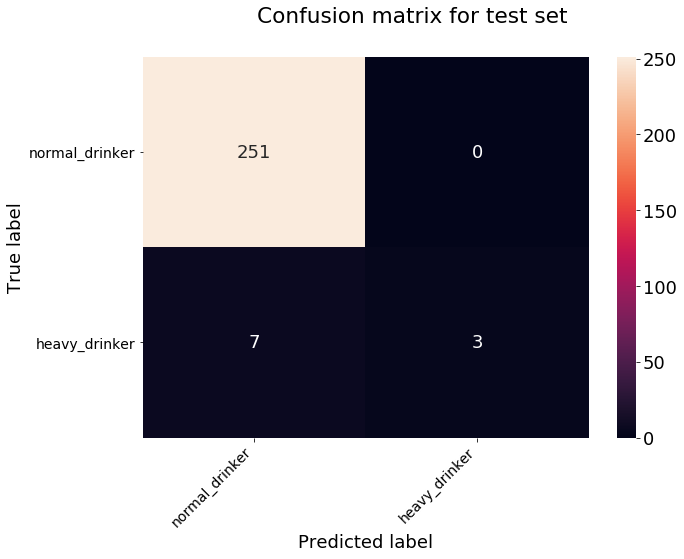

In [154]:
def exp4_classifier(X_train, y_train):
    
    return GradientBoostingClassifier(random_state=0)

exp4_eval = Evaluation().print_confusion_matrix
exp4 = Experiment()
gbdt_grid = exp4.run_experiment(asdp.data, "heavy_drinker", exp4_classifier, exp4_eval);



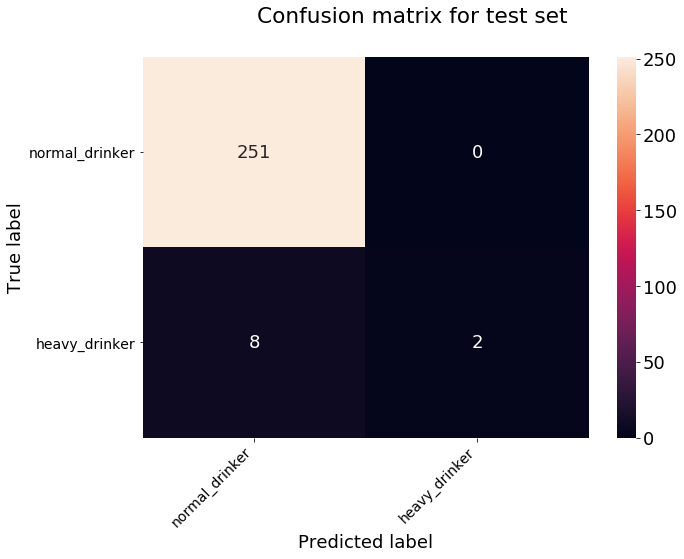

In [161]:
def exp5_classifier(X_train, y_train):
    
    clf = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
    
    param_grid = dict(loss=["deviance", "exponential"],
                     learning_rate=[0.1,0.2,0.5,0.8],
                     n_estimators=[50, 100, 150],
                    max_depth=[1,3,5],
                      max_features=["sqrt", "log2", 3] #using the rule of 3s
                     )
    
    return GridSearchCV(clf, param_grid=param_grid, cv=3, scoring="recall", iid=False) 

exp5_eval = Evaluation().print_confusion_matrix
exp5 = Experiment()
gbdt_grid = exp5.run_experiment(asdp.data, "heavy_drinker", exp5_classifier, exp5_eval);